In [1]:
import psi4
import forte

In [2]:
def run_psi4_scf(geom, basis, reference='rhf'):
    """
    Run a Psi4 SCF.
    :param geom: a string for molecular geometry
    :param basis: a string for basis set
    :param reference: a string for the type of reference
    :return: a tuple of (scf energy, psi4 Wavefunction)
    """
    psi4.core.clean()
    mol = psi4.geometry(geom)
    
    psi4.set_options({'basis': basis,
                      'reference': reference,
                      'scf_type': 'pk',
                      'e_convergence': 1e-8,
                      'd_convergence': 1e-6})
    psi4.core.set_output_file('output.dat', False)
    
    Escf, wfn = psi4.energy('scf', return_wfn=True)
    psi4.core.clean()
    return Escf, wfn

In [3]:
# water molecule

geom = """0 1
O
H 1 1.2
H 1 1.2 2 120.0
"""

basis = '6-31g'

# pre-run DOCC: [3,0,1,1]

In [4]:
Escf, wfn = run_psi4_scf(geom, basis, 'rhf')
print(f"RHF energy: {Escf:.8f} Eh")

RHF energy: -75.90316259 Eh


In [5]:
# Run Psi4 MP2
psi4.set_options({'mp2_type': 'conv',
                  'freeze_core': False})
Emp2_psi4 = psi4.energy('mp2')
print(f"All-electron MP2 energy from Psi4: {Emp2_psi4:.12f} Eh")

psi4.set_options({'mp2_type': 'conv',
                  'freeze_core': True})
Emp2_psi4 = psi4.energy('mp2')
print(f"Frozen-core MP2 energy from Psi4:  {Emp2_psi4:.12f} Eh")

All-electron MP2 energy from Psi4: -76.052693624331 Eh
Frozen-core MP2 energy from Psi4:  -76.051676060116 Eh


# Forte pymodule analog

Here I mimic what Forte pymodule.py does and prepare reference energy and RDMs for DSRG-PT2 or MP2.

Note that if you modify the following block but encounter any problems in the `pre_dsrg` function, you might trigger `ambit::initialize: Ambit has already been initialized.` error when you rerun the block.
I am not sure how to actually fix this error, but restart the jupyter kernal works.

In [6]:
from forte import forte_options

def pre_dsrg(ref_wfn, mo_spaces, rdm_level=3):
    """
    Preparation step for DSRG: compute a CAS and its RDMs.
    :param ref_wfn: reference wave function from psi4
    :param mo_spaces: a dictionary {mo_space: occupation}, e.g., {'ACTIVE': [0,0,0,0]}
    :param rdm_level: max RDM to be computed
    :return: a tuple of (reference energy, MOSpaceInfo, ForteIntegrals, RDMs)
    """
    
    forte.startup()
    
    # pass Psi4 options to Forte
    options = psi4.core.get_options()
    options.set_current_module('FORTE')
    forte_options.update_psi_options(options)
    
    # create a MOSpaceInfo object
    mo_space_info = forte.make_mo_space_info_from_map(wfn, mo_spaces, [])
    
    # make a ForteIntegral object
    ints = forte.make_forte_integrals(ref_wfn, options, mo_space_info)

    # create active space integrals for CASCI
    as_ints = forte.make_active_space_ints(mo_space_info, ints, "ACTIVE", ["RESTRICTED_DOCC"]);
    
    # SCFInfo object: stores doccpi, orbital energies, etc.
    scf_info = forte.SCFInfo(ref_wfn)
    
    # StateInfo: state irrep, multiplicity, nalpha electron, etc.
    state = forte.make_state_info_from_psi_wfn(ref_wfn)
    
    # build a map {StateInfo: a list of weights} for multi-state computations
    state_weights_map = forte.make_state_weights_map(forte_options, ref_wfn)
    print(state_weights_map)
    
    # converts {StateInfo: weights} to {StateInfo: nroots}
    state_map = forte.to_state_nroots_map(state_weights_map)
    print(state_map)
    
    # create an active space solver object and compute the energy
    as_solver_type = 'FCI'  # 'CAS', 'ACI', 'DMRG', 'V2RDM'
    as_solver = forte.make_active_space_solver(as_solver_type, state_map, scf_info,
                                               mo_space_info, as_ints, forte_options)
    state_energies_list = as_solver.compute_energy()  # a map {StateInfo: a list of energies}
    print(state_energies_list)
    
    # compute averaged energy --- reference energy for DSRG
    Eref = forte.compute_average_state_energy(state_energies_list, state_weights_map)
    
    # compute RDMs
    rdms = as_solver.compute_average_rdms(state_weights_map, rdm_level)
    
    # semicanonicalize orbitals
    semi = forte.SemiCanonical(mo_space_info, ints, forte_options)
    semi.semicanonicalize(rdms, rdm_level)
        
    return Eref, mo_space_info, ints, rdms

In [7]:
# occupations for H2O we will use for MP2 or DSRG-PT2
mo_spaces = {'FROZEN_DOCC': [1,0,0,0],
             'RESTRICTED_DOCC': [2,0,1,1],
             'ACTIVE': [0,0,0,0]}

Eref, mo_space_info, ints, rdms = pre_dsrg(wfn, mo_spaces)

{Singlet A1: [1.0]}
{Singlet A1: 1}
{Singlet A1: [-75.90316259194128]}


# MP2 energy expression

Please follow the notes. We use spin-integrated expression here.

\begin{equation}
E_\text{MP2} = \frac{1}{4} v_{i^\alpha j^\alpha}^{a^\alpha b^\alpha} t_{a^\alpha b^\alpha}^{i^\alpha j^\alpha}
+ \frac{1}{4} v_{i^\beta j^\beta}^{a^\beta b^\beta} t_{a^\beta b^\beta}^{i^\beta j^\beta}
+ v_{i^\alpha j^\beta}^{a^\alpha b^\beta} t_{a^\alpha b^\beta}^{i^\alpha j^\beta}.
\end{equation}

Since $v$ is Hermitian, we will put both $v$ and $t$ to shape $O \times O \times V \times V$.

In [8]:
import numpy as np

### Build Fock matrix

The general expression of spin-orbital Fock matrix is given by
\begin{equation}
f^p_q = h^p_q + \sum_{i} \langle pi || qi \rangle.
\end{equation}

We only need to build the $OO$, $VV$, and $OV$ blocks of the Fock matrix.

In [9]:
# figure out occupied and virtual MO indices
core_mos = mo_space_info.corr_absolute_mo("RESTRICTED_DOCC")
ncore = len(core_mos)
print(core_mos)

virt_mos = mo_space_info.corr_absolute_mo("RESTRICTED_UOCC")
nvirt = len(virt_mos)
print(virt_mos)

[0, 1, 6, 8]
[2, 3, 4, 5, 7, 9, 10, 11]


In [10]:
# build alpha Fock
def build_fock_a(core_mos, virt_mos):
    """
    Build alpha Fock matrix.
    :param core_mos: a list of core MO indices
    :param virt_mos: a list of virtual MO indices
    :return: the alpha Fock matrix in format {'oo': mat0, 'ov': mat1, 'vv': mat2}
    """
    ncore = len(core_mos)
    nvirt = len(virt_mos)
    
    Fa = {'oo': ints.oei_a_block(core_mos, core_mos),
          'vv': ints.oei_a_block(virt_mos, virt_mos),
          'ov': ints.oei_a_block(core_mos, virt_mos)}
    
    # OO block
    v = ints.tei_aa_block(core_mos, core_mos, core_mos, core_mos)
    Fa['oo'] += np.einsum('piqi->pq', v)
    
    v = ints.tei_ab_block(core_mos, core_mos, core_mos, core_mos)
    Fa['oo'] += np.einsum('piqi->pq', v)
    
    # VV block
    v = ints.tei_aa_block(virt_mos, core_mos, virt_mos, core_mos)
    Fa['vv'] += np.einsum('piqi->pq', v)
    
    v = ints.tei_ab_block(virt_mos, core_mos, virt_mos, core_mos)
    Fa['vv'] += np.einsum('piqi->pq', v)
    
    # OV block
    v = ints.tei_aa_block(core_mos, core_mos, virt_mos, core_mos)
    Fa['ov'] += np.einsum('piqi->pq', v)
    
    v = ints.tei_ab_block(core_mos, core_mos, virt_mos, core_mos)
    Fa['ov'] += np.einsum('piqi->pq', v)

    return Fa

Fa = build_fock_a(core_mos, virt_mos)
Fa

{'oo': array([[-1.24924492e+00, -1.06466738e-09,  0.00000000e+00,
          0.00000000e+00],
        [-1.06466677e-09, -4.97927646e-01,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -4.84137930e-01,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -6.08570525e-01]]),
 'vv': array([[ 1.27308291e-01, -2.73991069e-09, -2.01498290e-10,
         -4.78634560e-09,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.73991202e-09,  9.32975278e-01,  3.45481502e-09,
         -1.20797748e-09,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.01498568e-10,  3.45481513e-09,  1.22639518e+00,
         -6.93032763e-10,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-4.78634715e-09, -1.20797676e-09, -6.93031344e-10,
          1.59936504e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, 

In [11]:
# build beta Fock
def build_fock_b(core_mos, virt_mos):
    """
    Build beta Fock matrix.
    :param core_mos: a list of core MO indices
    :param virt_mos: a list of virtual MO indices
    :return: the beta Fock matrix in format {'oo': mat0, 'ov': mat1, 'vv': mat2}
    """
    ncore = len(core_mos)
    nvirt = len(virt_mos)
    
    Fb = {'oo': ints.oei_b_block(core_mos, core_mos),
          'vv': ints.oei_b_block(virt_mos, virt_mos),
          'ov': ints.oei_b_block(core_mos, virt_mos)}
    
    # OO block
    v = ints.tei_bb_block(core_mos, core_mos, core_mos, core_mos)
    Fb['oo'] += np.einsum('piqi->pq', v)
    
    v = ints.tei_ab_block(core_mos, core_mos, core_mos, core_mos)
    Fb['oo'] += np.einsum('ipiq->pq', v)
    
    # VV block
    v = ints.tei_bb_block(virt_mos, core_mos, virt_mos, core_mos)
    Fb['vv'] += np.einsum('piqi->pq', v)
    
    v = ints.tei_ab_block(core_mos, virt_mos, core_mos, virt_mos)
    Fb['vv'] += np.einsum('ipiq->pq', v)
    
    # OV block
    v = ints.tei_bb_block(core_mos, core_mos, virt_mos, core_mos)
    Fb['ov'] += np.einsum('piqi->pq', v)
    
    v = ints.tei_ab_block(core_mos, core_mos, core_mos, virt_mos)
    Fb['ov'] += np.einsum('ipiq->pq', v)

    return Fb

Fb = build_fock_b(core_mos, virt_mos)
Fb

{'oo': array([[-1.24924492e+00, -1.06466738e-09,  0.00000000e+00,
          0.00000000e+00],
        [-1.06466677e-09, -4.97927646e-01,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00, -4.84137930e-01,
          0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         -6.08570525e-01]]),
 'vv': array([[ 1.27308291e-01, -2.73991069e-09, -2.01498290e-10,
         -4.78634560e-09,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.73991202e-09,  9.32975278e-01,  3.45481502e-09,
         -1.20797748e-09,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-2.01498568e-10,  3.45481513e-09,  1.22639518e+00,
         -6.93032763e-10,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-4.78634715e-09, -1.20797676e-09, -6.93031344e-10,
          1.59936504e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00, 

In [12]:
# test if alpha and beta Fock matrices are indentical
assert np.all(np.abs(Fa['oo'] - Fb['oo']) < 1.0e-10)
assert np.all(np.abs(Fa['ov'] - Fb['ov']) < 1.0e-10)
assert np.all(np.abs(Fa['vv'] - Fb['vv']) < 1.0e-10)

### Build MP2 amplitudes

The spin-orbital MP2 amplitudes read as
\begin{align}
t^{ij}_{ab} = \frac{v^{ij}_{ab}}{\epsilon_i + \epsilon_j - \epsilon_a - \epsilon_b}.
\end{align}

For convenience, the energy denominator is denoated as
\begin{equation}
\Delta^{ij}_{ab} \equiv \epsilon_i + \epsilon_j - \epsilon_a - \epsilon_b.
\end{equation}

In [13]:
# build orbital energies
Fdiag = {'o': np.diag(Fa['oo']), 'v': np.diag(Fa['vv'])}
Fdiag

{'o': array([-1.24924492, -0.49792765, -0.48413793, -0.60857053]),
 'v': array([0.12730829, 0.93297528, 1.22639518, 1.59936504, 1.17146004,
        0.23287538, 1.01274298, 1.43891752])}

In [14]:
# grab 2e-integrals
V = {'aa': ints.tei_aa_block, 'ab': ints.tei_ab_block, 'bb': ints.tei_bb_block}

Vaa = V['aa'](core_mos, core_mos, virt_mos, virt_mos)
Vab = V['ab'](core_mos, core_mos, virt_mos, virt_mos)
Vbb = V['bb'](core_mos, core_mos, virt_mos, virt_mos)

In [15]:
# build MP2 amplitudes
def build_amplitudes_mp2(Fdiag, V_spin):
    """
    Build MP2 amplitudes for spin cases corresponding to V.
    :param Fdiag: a map for orbital energies {'o': occupied epsilon, 'v': virtual epsilon}
    :param V: spin cases for antisymmetrized 2e-integrals
    :return: the MP2 amplitudes
    """
    T = V[V_spin](core_mos, core_mos, virt_mos, virt_mos).copy()
    for ii, i in enumerate(Fdiag['o']):
        for ij, j in enumerate(Fdiag['o']):
            for ia, a in enumerate(Fdiag['v']):
                for ib, b in enumerate(Fdiag['v']):
                    T[ii][ij][ia][ib] /= i + j - a - b
    return T

In [16]:
Taa = build_amplitudes_mp2(Fdiag, 'aa')
Tab = build_amplitudes_mp2(Fdiag, 'ab')
Tbb = build_amplitudes_mp2(Fdiag, 'bb')

In [17]:
# contract 2e-integrals with 2-amplitudes
def contraction(v, t, factor):
    """
    Fully contract v and t.
    :param v: 2e-integrals
    :param t: 2-amplitudes
    :param factor: scaling factor
    :return: the contracted value
    """
    return factor * np.einsum('ijab,ijab->', v, t)

In [18]:
# compute MP2 energy
Emp2_corr = contraction(Vaa, Taa, 0.25) + contraction(Vbb, Tbb, 0.25) \
          + contraction(Vab, Tab, 1.0)
Emp2 = Eref + Emp2_corr
print(f"MP2 correlation energy:     {Emp2_corr:18.12f}")
print(f"MP2 total energy tutorial:  {Emp2:18.12f}")
print(f"MP2 total energy from Psi4: {Emp2_psi4:18.12f}")

MP2 correlation energy:        -0.148513467373
MP2 total energy tutorial:    -76.051676059314
MP2 total energy from Psi4:   -76.051676060116


In [19]:
assert(abs(Emp2 - Emp2_psi4) < 1.0e-8)

# DSRG-PT2 energy expression

In DSRG-PT2, we introduce the flow parameter $s \in [0, \infty)$.

The DSRG-PT2 energy expression is given by
\begin{equation}
E_\text{DSRG-PT2} = \frac{1}{4} \tilde{v}_{i^\alpha j^\alpha}^{a^\alpha b^\alpha} t_{a^\alpha b^\alpha}^{i^\alpha j^\alpha}
+ \frac{1}{4} \tilde{v}_{i^\beta j^\beta}^{a^\beta b^\beta} t_{a^\beta b^\beta}^{i^\beta j^\beta}
+ \tilde{v}_{i^\alpha j^\beta}^{a^\alpha b^\beta} t_{a^\alpha b^\beta}^{i^\alpha j^\beta}.
\end{equation}
The spin-orbital renormalized 2e-integrals are
\begin{equation}
\tilde{v}_{ij}^{ab} = v_{ij}^{ab} \left[ 1 + e^{-s (\Delta^{ij}_{ab})^2} \right],
\end{equation}
and the spin-orbital amplitudes are expressed as
\begin{equation}
t^{ij}_{ab} = v^{ij}_{ab} \frac{1 - e^{-s (\Delta^{ij}_{ab})^2}}{\Delta^{ij}_{ab}}.
\end{equation}

In [20]:
flow_param = 1.0

In [21]:
# renormalize 2e-integrals
def renorm_aptei(Fdiag, V_spin, s):
    """
    Renormalize antisymmetrized 2e-integrals for DSRG-PT2.
    :param Fdiag: a map for orbital energies {'o': occupied epsilon, 'v': virtual epsilon}
    :param V_spin: spin case for antisymmetrized 2e-integrals
    :param s: the DSRG flow parameter
    :return: the renormalized 2e-integrals
    """
    R = V[V_spin](core_mos, core_mos, virt_mos, virt_mos).copy()
    for ii, i in enumerate(Fdiag['o']):
        for ij, j in enumerate(Fdiag['o']):
            for ia, a in enumerate(Fdiag['v']):
                for ib, b in enumerate(Fdiag['v']):
                    delta = i + j - a - b
                    R[ii][ij][ia][ib] *= 1.0 + np.exp(-s * delta ** 2)
    return R

rVaa = renorm_aptei(Fdiag, 'aa', flow_param)
rVab = renorm_aptei(Fdiag, 'ab', flow_param)
rVbb = renorm_aptei(Fdiag, 'bb', flow_param)

In [22]:
# build DSRG-PT2 amplitudes
def build_amplitudes_pt2(Fdiag, V_spin, s):
    """
    Build DSRG-PT2 amplitudes for spin cases corresponding to V.
    :param Fdiag: a map for orbital energies {'o': occupied epsilon, 'v': virtual epsilon}
    :param V_spin: spin case for antisymmetrized 2e-integrals
    :param s: the DSRG flow parameter
    :return: the DSR-PT2 amplitudes
    """
    T = V[V_spin](core_mos, core_mos, virt_mos, virt_mos).copy()
    for ii, i in enumerate(Fdiag['o']):
        for ij, j in enumerate(Fdiag['o']):
            for ia, a in enumerate(Fdiag['v']):
                for ib, b in enumerate(Fdiag['v']):
                    delta = i + j - a - b
                    if abs(delta) < 1.0e-8:
                        value = 0.0
                    else:
                        value = (1.0 - np.exp(-s * delta ** 2)) / delta
                    T[ii][ij][ia][ib] *= value
    return T

rTaa = build_amplitudes_pt2(Fdiag, 'aa', flow_param)
rTab = build_amplitudes_pt2(Fdiag, 'ab', flow_param)
rTbb = build_amplitudes_pt2(Fdiag, 'bb', flow_param)

In [23]:
# compute DSRG-PT2 energy
Ept2_corr = contraction(rVaa, rTaa, 0.25) + contraction(rVbb, rTbb, 0.25) \
          + contraction(rVab, rTab, 1.0)
Ept2 = Eref + Ept2_corr
print(f"DSRG-PT2 correlation energy:     {Ept2_corr:18.12f}")
print(f"DSRG-PT2 total energy tutorial:  {Ept2:18.12f}")
print(f"MP2 total energy from Psi4:      {Emp2_psi4:18.12f}")

DSRG-PT2 correlation energy:        -0.148255452641
DSRG-PT2 total energy tutorial:    -76.051418044582
MP2 total energy from Psi4:        -76.051676060116


In [24]:
# play around with flow parameter
def compute_dsrgpt2_energy(s):
    """
    Compute the DSRG-PT2 energy.
    :param s: the DSRG flow parameter
    :return: the DSRG-PT2 correlation energy
    """
    rV = renorm_aptei(Fdiag, 'aa', s)
    rT = build_amplitudes_pt2(Fdiag, 'aa', s)
    Eout = contraction(rV, rT, 0.25)
    
    rV = renorm_aptei(Fdiag, 'bb', s)
    rT = build_amplitudes_pt2(Fdiag, 'bb', s)
    Eout += contraction(rV, rT, 0.25)
    
    rV = renorm_aptei(Fdiag, 'ab', s)
    rT = build_amplitudes_pt2(Fdiag, 'ab', s)
    Eout += contraction(rV, rT, 1.0)
    
    return Eout

In [25]:
dsrg_s = [0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 5.0, 7.5, 10.0, 25.0, 50.0, 100.0, 1000.0]
energies = [compute_dsrgpt2_energy(s) for s in dsrg_s]

In [26]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib notebook
mpl.rcParams['pdf.fonttype'] = 42

<IPython.core.display.Javascript object>


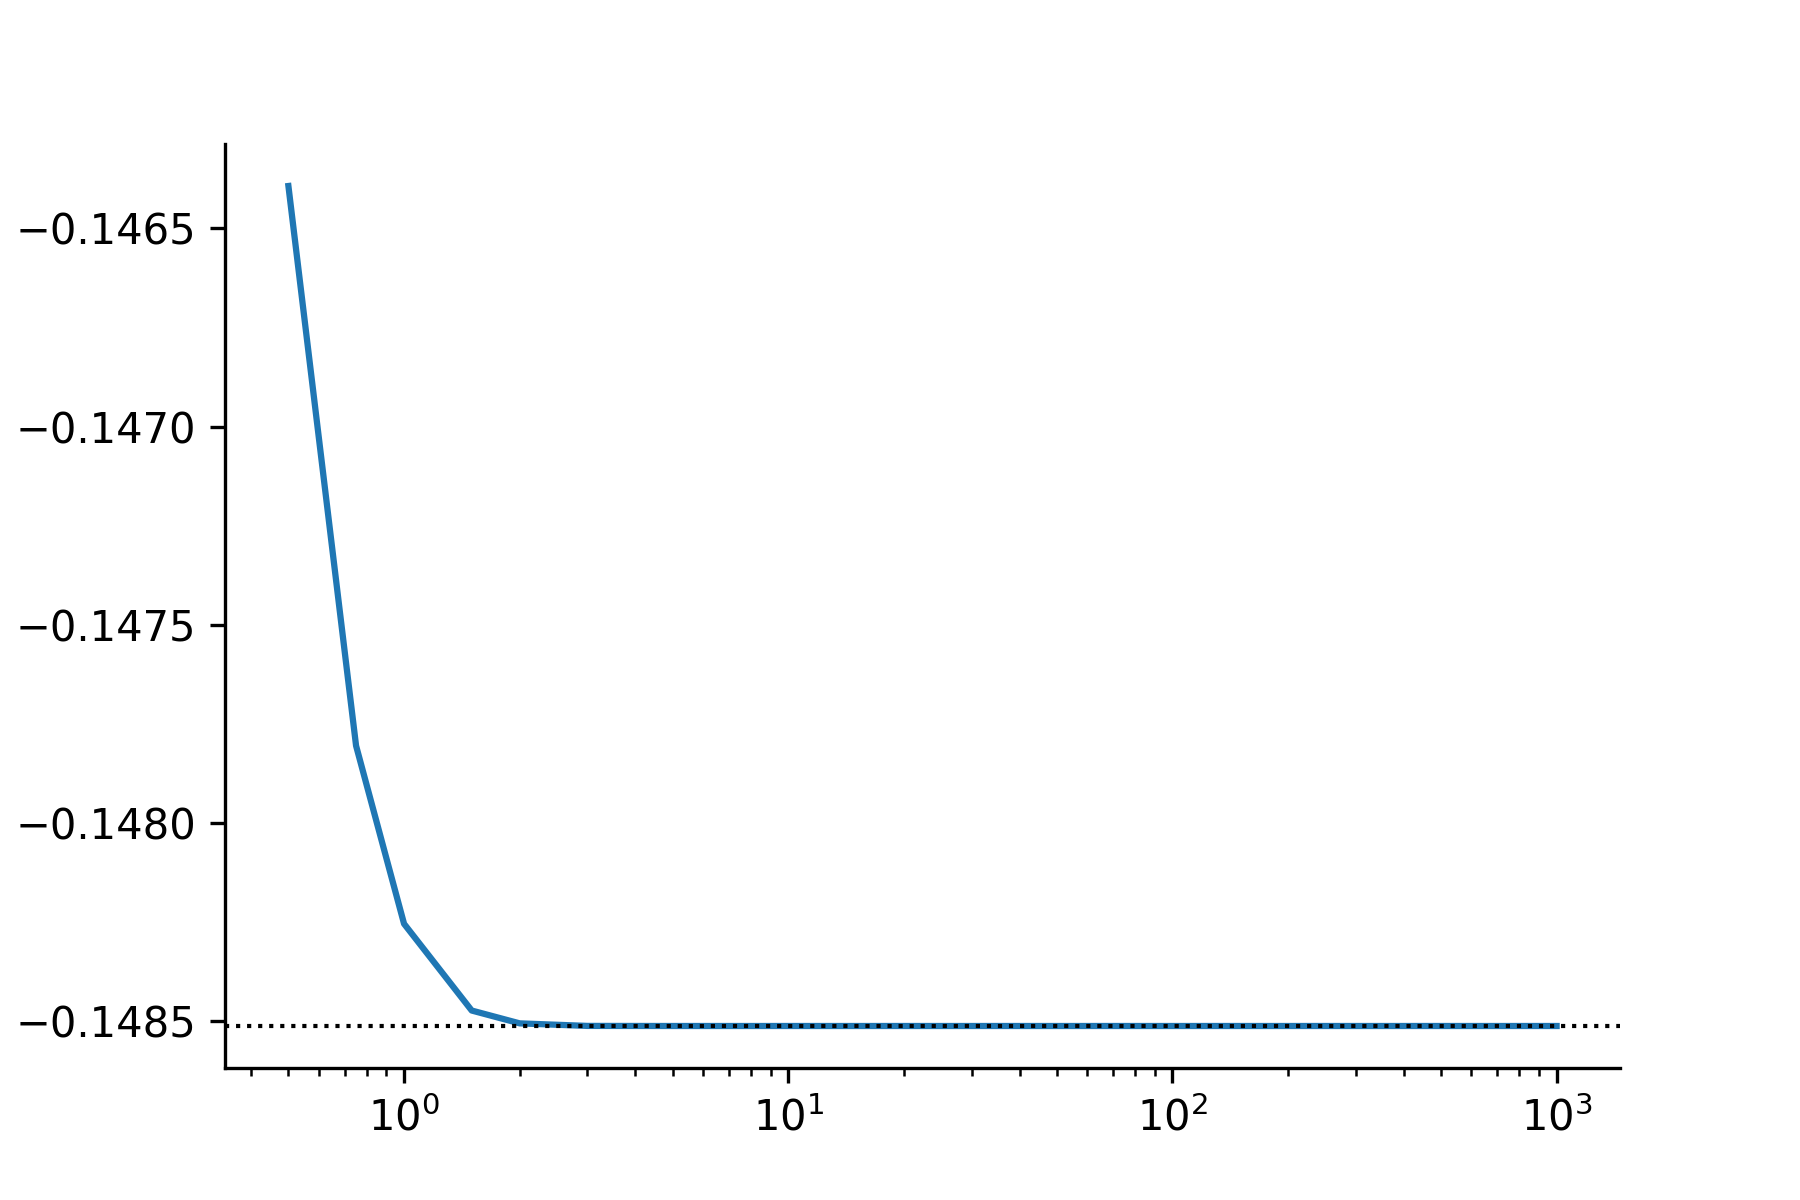

In [27]:
fig = plt.figure(figsize=(6,4), dpi=150)
ax = plt.subplot(111)
ax.semilogx(dsrg_s, energies)
ax.axhline(Emp2_corr, lw=1.0, ls=':', color='k')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)